# **Named Entity Recognition**

## **Importing Libraries**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pandas as pd
import numpy as np
np.random.seed(0)

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import Model, Input
from keras.layers import LSTM, Embedding, Dense
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping
!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf

# Configure MPS for Apple Silicon (M1/M2/M3)
# TensorFlow automatically detects and uses MPS on Apple Silicon
try:
    physical_devices = tf.config.list_physical_devices()
    print("Available devices:", [str(d) for d in physical_devices])
except Exception as e:
    print(f"Device check: {e}")

import keras.backend as K
from keras.utils import plot_model

import nltk
# nltk.download()
# nltk.download('stopwords')
from nltk.corpus import stopwords

# from google.colab import drive

Available devices: ["PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')"]


## **Taking input from Dataset**

In [2]:
#Importing the dataset from drive

# drive.mount("/content/gdrive")
data = pd.read_csv("./ner_dataset.csv", encoding = "latin1")
data = data.fillna(method="ffill")  # Use ffill() method directly: data.ffill()

/var/folders/mr/9h0jh58569g1b3ynbqsf4z200000gn/T/ipykernel_28351/3653266127.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")  # Use ffill() method directly: data.ffill()


In [3]:
data.head(25)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [4]:
#Functions to clean data for various cases

def removeStopWords(df1):
  sentence = df1["Sentence #"]
  words = df1["Word"]
  POS = df1["POS"]
  Tag = df1["Tag"]
  sw = set(stopwords.words('english'))

  rows = []
  for i in range(len(df1)):
    if words[i] not in sw:
      rows.append({"Sentence #" : sentence[i], "Word" : words[i], "POS" : POS[i], "Tag" : Tag[i]})
  df2 = pd.DataFrame(rows)
  columns = ["Sentence #", "Word", "POS", "Tag"]
  if len(df2) > 0:
    df2 = df2[columns]
  return df2

def removeO(df1):
  sentence = df1["Sentence #"]
  words = df1["Word"]
  POS = df1["POS"]
  Tag = df1["Tag"]
  rows = []
  for i in range(len(df1)):
    if Tag[i] != 'O':
      rows.append({"Sentence #" : sentence[i], "Word" : words[i], "POS" : POS[i], "Tag" : Tag[i]})
  df2 = pd.DataFrame(rows)
  columns = ["Sentence #", "Word", "POS", "Tag"]
  if len(df2) > 0:
    df2 = df2[columns]  
  return df2

#Adding custom metrics as Keras don't support these by default

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='prp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        pp = tf.reduce_sum(y_true)
        prp = tf.reduce_sum(y_pred)
        self.true_positives.assign_add(tp)
        self.possible_positives.assign_add(pp)
        self.predicted_positives.assign_add(prp)

    def result(self):
        precision = self.true_positives / (self.predicted_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.possible_positives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

    def reset_state(self):
        self.true_positives.assign(0)
        self.possible_positives.assign(0)
        self.predicted_positives.assign(0)

class Recall(tf.keras.metrics.Metric):
    def __init__(self, name='recall', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        pp = tf.reduce_sum(y_true)
        self.true_positives.assign_add(tp)
        self.possible_positives.assign_add(pp)

    def result(self):
        return self.true_positives / (self.possible_positives + tf.keras.backend.epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.possible_positives.assign(0)

class Precision(tf.keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='prp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        prp = tf.reduce_sum(y_pred)
        self.true_positives.assign_add(tp)
        self.predicted_positives.assign_add(prp)

    def result(self):
        return self.true_positives / (self.predicted_positives + tf.keras.backend.epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)

# Create metric instances
get_f1 = F1Score(name='get_f1')
precision_m = Precision(name='precision_m')
recall_m = Recall(name='recall_m')

# **EDA**

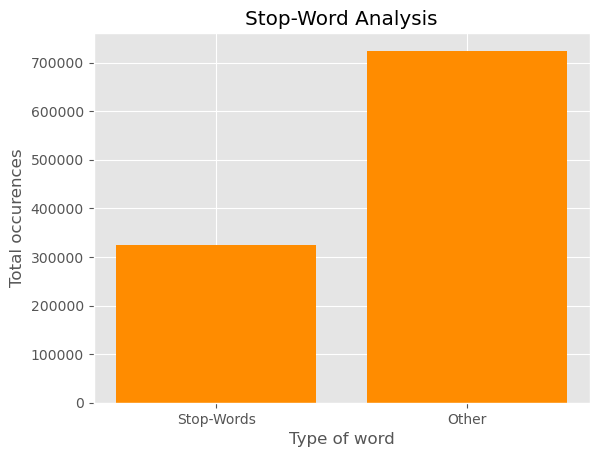

In [5]:
#Plot for Stop-Words in our corpus
def swAnalysis(dataset):
  cnt = 0
  sw = set(stopwords.words('english'))
  for x in dataset["Word"]:
    if x in sw:
      cnt += 1

  data = {'Stop-Words':cnt, 'Other':len(dataset) - cnt} 
  fields = list(data.keys()) 
  values = list(data.values()) 
    
  # fig = plt.figure(figsize = (6, 3)) 
    
  # creating the bar plot 
  plt.bar(fields, values, color ='darkorange') 
    
  plt.xlabel("Type of word") 
  plt.ylabel("Total occurences") 
  plt.title("Stop-Word Analysis") 
  plt.show() 

swAnalysis(data)

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64


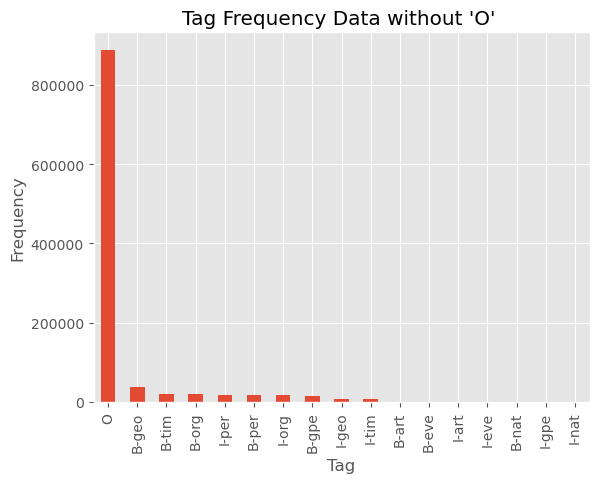

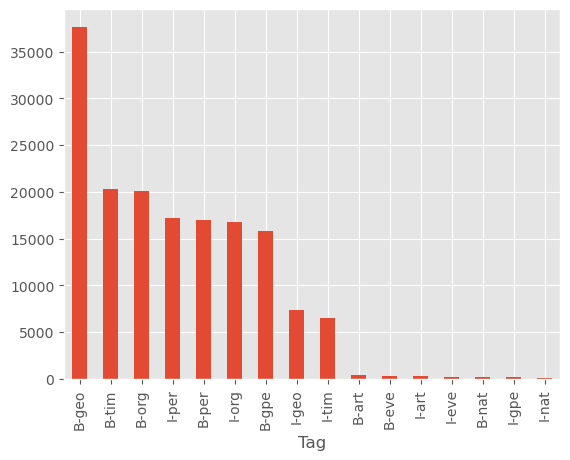

In [6]:
#Distribution of Tags

fig, ax = plt.subplots()
plt.title("Tag Frequency Data without 'O' ")
plt.xlabel("Tags")
plt.ylabel("Frequency")
print(data['Tag'].value_counts())
df = data['Tag'].value_counts()

df.plot(ax=ax, kind='bar')
plt.show()

fig, ax = plt.subplots()
df = data['Tag'].value_counts().drop('O')
df.plot(ax=ax, kind='bar')
plt.show()

In [7]:
#Analysis of Dataset

print("Total unique words in corpus :", len(data["Word"].unique()))
print("Total unique entities in our dataset :", len(data["Tag"].unique()))

Total unique words in corpus : 35177
Total unique entities in our dataset : 17


In [8]:
#Getting all unique words
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [9]:
#Getting all unique tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [10]:
print(tags)

['B-gpe', 'B-art', 'B-tim', 'I-org', 'I-gpe', 'I-geo', 'B-nat', 'B-eve', 'B-per', 'B-geo', 'O', 'I-eve', 'I-art', 'B-org', 'I-nat', 'I-tim', 'I-per']


In [11]:
print(num_words, num_tags)

35178 17


In [12]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [13]:
getter = SentenceGetter(data)
sentences = getter.sentences

/var/folders/mr/9h0jh58569g1b3ynbqsf4z200000gn/T/ipykernel_28351/1781754323.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


In [14]:
#Retrieving a sentence
sentences[0:5]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

## **Defining mapping between Words and Tags**

In [15]:
#Defining mapping between sentences and tags
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
tag2idx

{'B-gpe': 0,
 'B-art': 1,
 'B-tim': 2,
 'I-org': 3,
 'I-gpe': 4,
 'I-geo': 5,
 'B-nat': 6,
 'B-eve': 7,
 'B-per': 8,
 'B-geo': 9,
 'O': 10,
 'I-eve': 11,
 'I-art': 12,
 'B-org': 13,
 'I-nat': 14,
 'I-tim': 15,
 'I-per': 16}

## **Padding Input Sentences**

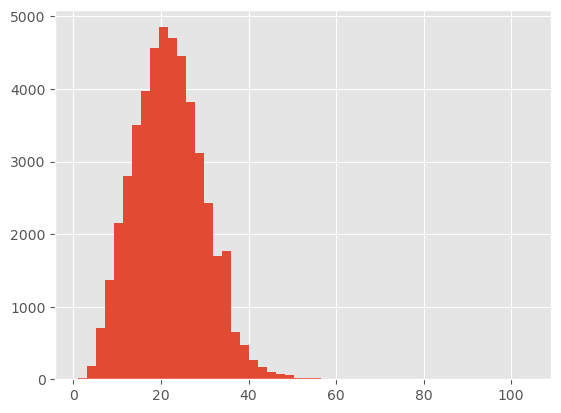

In [17]:
#Padding Input sentences as our input size i.e sentence length is variable.
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

# **Some Experimentation**


In [18]:
def plotMetrics(model):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def run(currDF):
  wordsx = list(set(currDF["Word"].values))
  wordsx.append("ENDPAD")
  num_words = len(wordsx)
  tags = list(set(currDF["Tag"].values))
  num_tags = len(tags)

  getter = SentenceGetter(currDF)
  sents = getter.sentences
  word2idx = {w: i+1 for i, w in enumerate(wordsx)}
  tag2idx = {t: i for i, t in enumerate(tags)}
  max_len = 60

  X = [[word2idx[w[0]] for w in s] for s in sents]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

  y = [[tag2idx[w[2]] for w in s] for s in sents]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  y = [to_categorical(i, num_classes = num_tags) for i in y]

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

  input_word = Input(shape = (max_len,))
  model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
  model = SpatialDropout1D(0.1)(model)
  model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
  out = TimeDistributed(Dense(num_tags, activation = "softmax"))(model)
  model = Model(input_word, out)
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", get_f1, precision_m, recall_m])

  #early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 1, verbose = 0, mode = "max")
  #early_stopping = EarlyStopping(monitor = "val_accuracy", verbose = 0, mode = "max")
  
  callbacks = [PlotLossesCallback()]

  history = model.fit(
      x_train, np.array(y_train),
      validation_split = 0.2,
      batch_size = 32,
      epochs = 10,
      verbose = 1,
      callbacks = callbacks
  )

  return history


In [19]:
#From above plot it can be seen that a maximum padding length of 60 is a safe bet.
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes = num_tags) for i in y]

In [20]:
#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## **Building and Compiling BI_LSTM**

In [21]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags, activation = "softmax"))(model)
model = Model(input_word, out)
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 50)         │     1,758,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 200)        │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 17)         │         3,417 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,883,117 (7.18 MB)

 Trainable params: 1,883,117 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [23]:
#For this project, we will be using the adam optimizer which is combination of gradient descent with momentum and RMS Prop.
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", get_f1, precision_m, recall_m])

# **Training the Model**

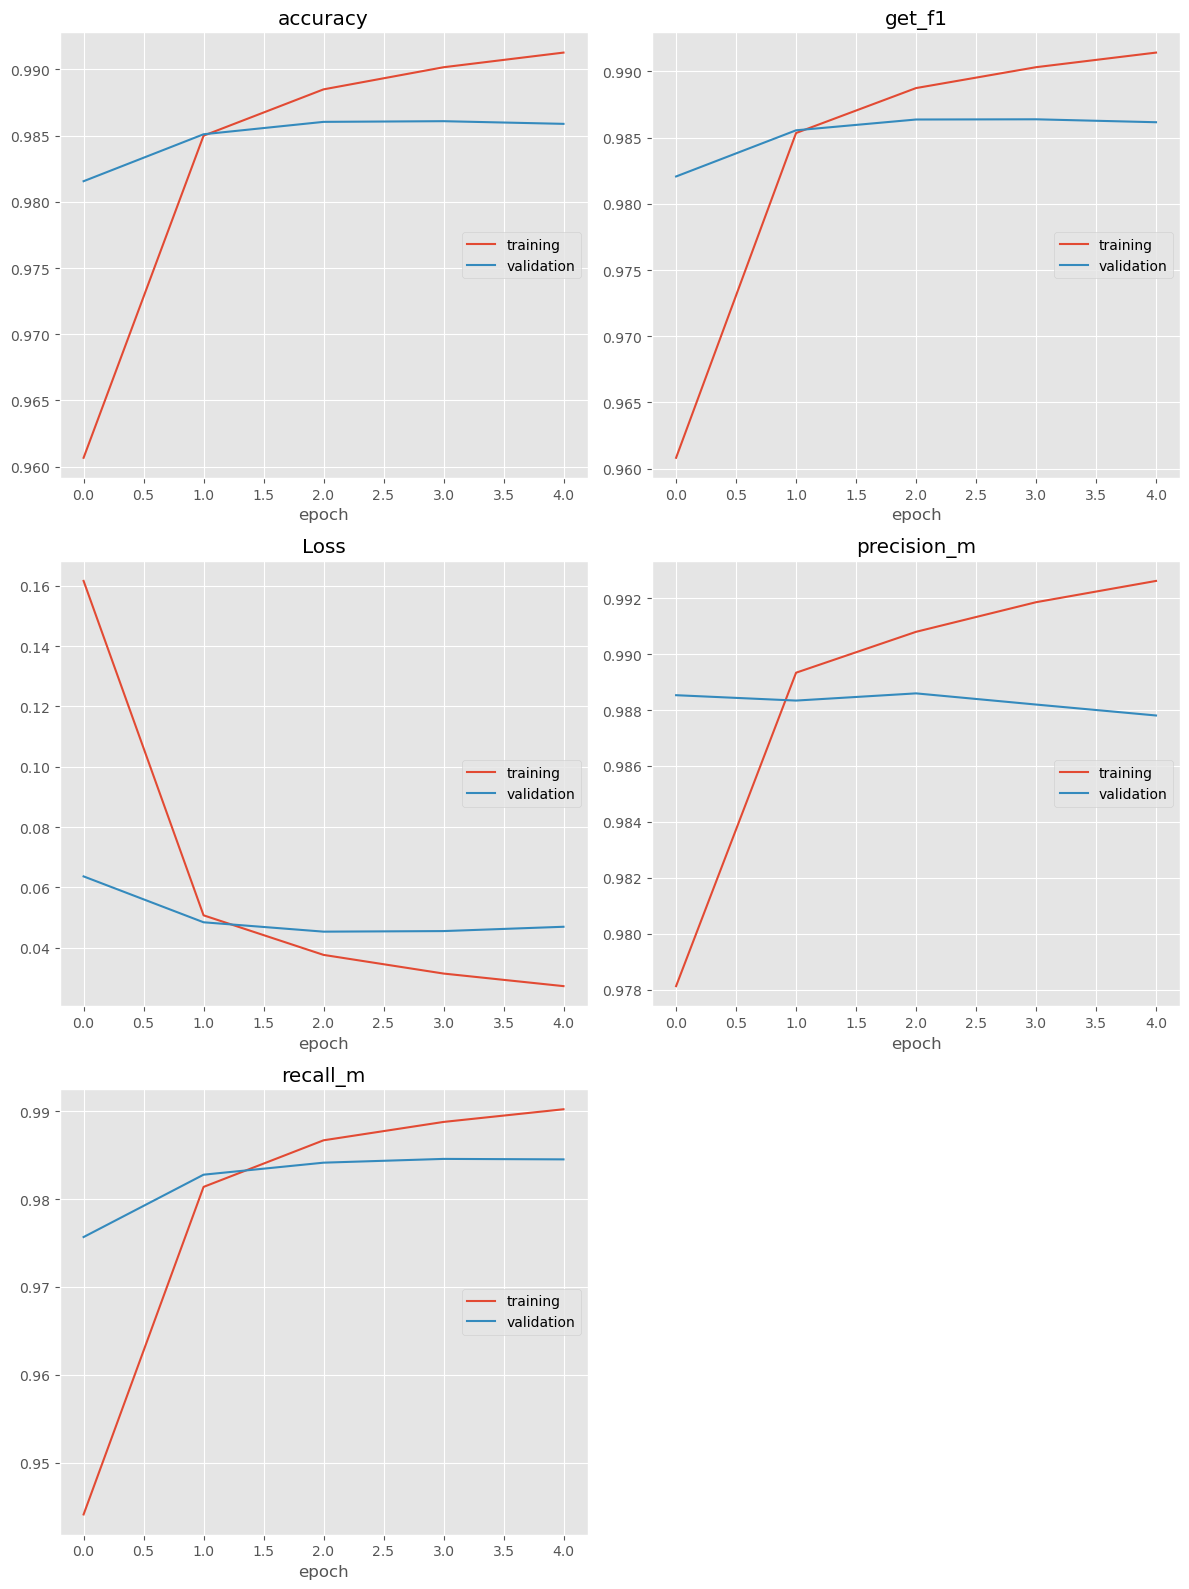

accuracy
	training         	 (min:    0.961, max:    0.991, cur:    0.991)
	validation       	 (min:    0.982, max:    0.986, cur:    0.986)
get_f1
	training         	 (min:    0.961, max:    0.991, cur:    0.991)
	validation       	 (min:    0.982, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.027, max:    0.162, cur:    0.027)
	validation       	 (min:    0.045, max:    0.064, cur:    0.047)
precision_m
	training         	 (min:    0.978, max:    0.993, cur:    0.993)
	validation       	 (min:    0.988, max:    0.989, cur:    0.988)
recall_m
	training         	 (min:    0.944, max:    0.990, cur:    0.990)
	validation       	 (min:    0.976, max:    0.985, cur:    0.985)
1080/1080 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.9915 - get_f1: 0.9917 - loss: 0.0266 - precision_m: 0.9929 - recall_m: 0.9905 - val_accuracy: 0.9859 - val_get_f1: 0.9862 - val_loss: 0.0470 - val_precision_m: 0.9878 - val_recall_m: 0.9845


In [24]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 1, verbose = 0, mode = "max")
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split = 0.2,
    batch_size = 32,
    epochs = 6,
    verbose = 1,
    callbacks = callbacks
)

# **Evaluation**

In [25]:
model.evaluate(x_test, np.array(y_test))

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9853 - get_f1: 0.9857 - loss: 0.0489 - precision_m: 0.9875 - recall_m: 0.9840


[0.04700077697634697,
 0.9859259724617004,
 0.9862537384033203,
 0.9880059361457825,
 0.9845079183578491]

In [26]:
i = 5
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
print(p)

y_true = np.argmax(np.array(y_test), axis = -1)[i]
print(y_true)
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))

print("-"*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  10 10]]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]
Word           True 	 Pred

------------------------------
The            O	O
winners        O	O
in             O	O
the            O	O
round          O	O
of             O	O
16             O	O
make           O	O
the            O	O
quarterfinals  O	O
.              O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
Westerners     O	O
W

In [27]:
print(y_test[1])
y_true = np.argmax(np.array(y_test), axis = -1)[1]
y_true

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  0, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

# **Some Experimentation**

In [28]:
def plotMetrics(model):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def run(currDF):
  wordsx = list(set(currDF["Word"].values))
  wordsx.append("ENDPAD")
  num_words = len(wordsx)
  tags = list(set(currDF["Tag"].values))
  num_tags = len(tags)

  getter = SentenceGetter(currDF)
  sents = getter.sentences
  word2idx = {w: i+1 for i, w in enumerate(wordsx)}
  tag2idx = {t: i for i, t in enumerate(tags)}
  max_len = 60

  X = [[word2idx[w[0]] for w in s] for s in sents]
  X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

  y = [[tag2idx[w[2]] for w in s] for s in sents]
  y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
  y = [to_categorical(i, num_classes = num_tags) for i in y]

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

  input_word = Input(shape = (max_len,))
  model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
  model = SpatialDropout1D(0.1)(model)
  model = Bidirectional(LSTM(units = 100, return_sequences = True, recurrent_dropout = 0.1))(model)
  out = TimeDistributed(Dense(num_tags, activation = "softmax"))(model)
  model = Model(input_word, out)
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", get_f1, precision_m, recall_m])

  #early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 1, verbose = 0, mode = "max")
  #early_stopping = EarlyStopping(monitor = "val_accuracy", verbose = 0, mode = "max")
  
  callbacks = [PlotLossesCallback()]

  history = model.fit(
      x_train, np.array(y_train),
      validation_split = 0.2,
      batch_size = 32,
      epochs = 10,
      verbose = 1,
      callbacks = callbacks
  )

  return history

In [29]:
datasw = removeStopWords(data[0: int(len(data)/10)])
print(datasw.head())
print(len(datasw))

    Sentence #           Word  POS    Tag
0  Sentence: 1      Thousands  NNS      O
1  Sentence: 1  demonstrators  NNS      O
2  Sentence: 1        marched  VBN      O
3  Sentence: 1         London  NNP  B-geo
4  Sentence: 1        protest   VB      O
72231


In [30]:
dataO = removeO(data[0: int(len(data)/10)])

# Use pd.concat instead of append (pandas 2.0+)
new_row = pd.DataFrame([{"Sentence #" : "Sentence: 47959", "Word" : "marched", "POS" : "VPN", "Tag" : "O"}])
dataO = pd.concat([dataO, new_row], ignore_index=True)
print(dataO)
print(len(dataO))

            Sentence #      Word  POS    Tag
0          Sentence: 1    London  NNP  B-geo
1          Sentence: 1      Iraq  NNP  B-geo
2          Sentence: 1   British   JJ  B-gpe
3          Sentence: 2      Bush  NNP  B-per
4          Sentence: 3      Hyde  NNP  B-geo
...                ...       ...  ...    ...
16019   Sentence: 4766  Espersen  NNP  B-per
16020   Sentence: 4766   Denmark  NNP  B-geo
16021   Sentence: 4768    August  NNP  B-tim
16022   Sentence: 4768      Dane   NN  B-gpe
16023  Sentence: 47959   marched  VPN      O

[16024 rows x 4 columns]
16024


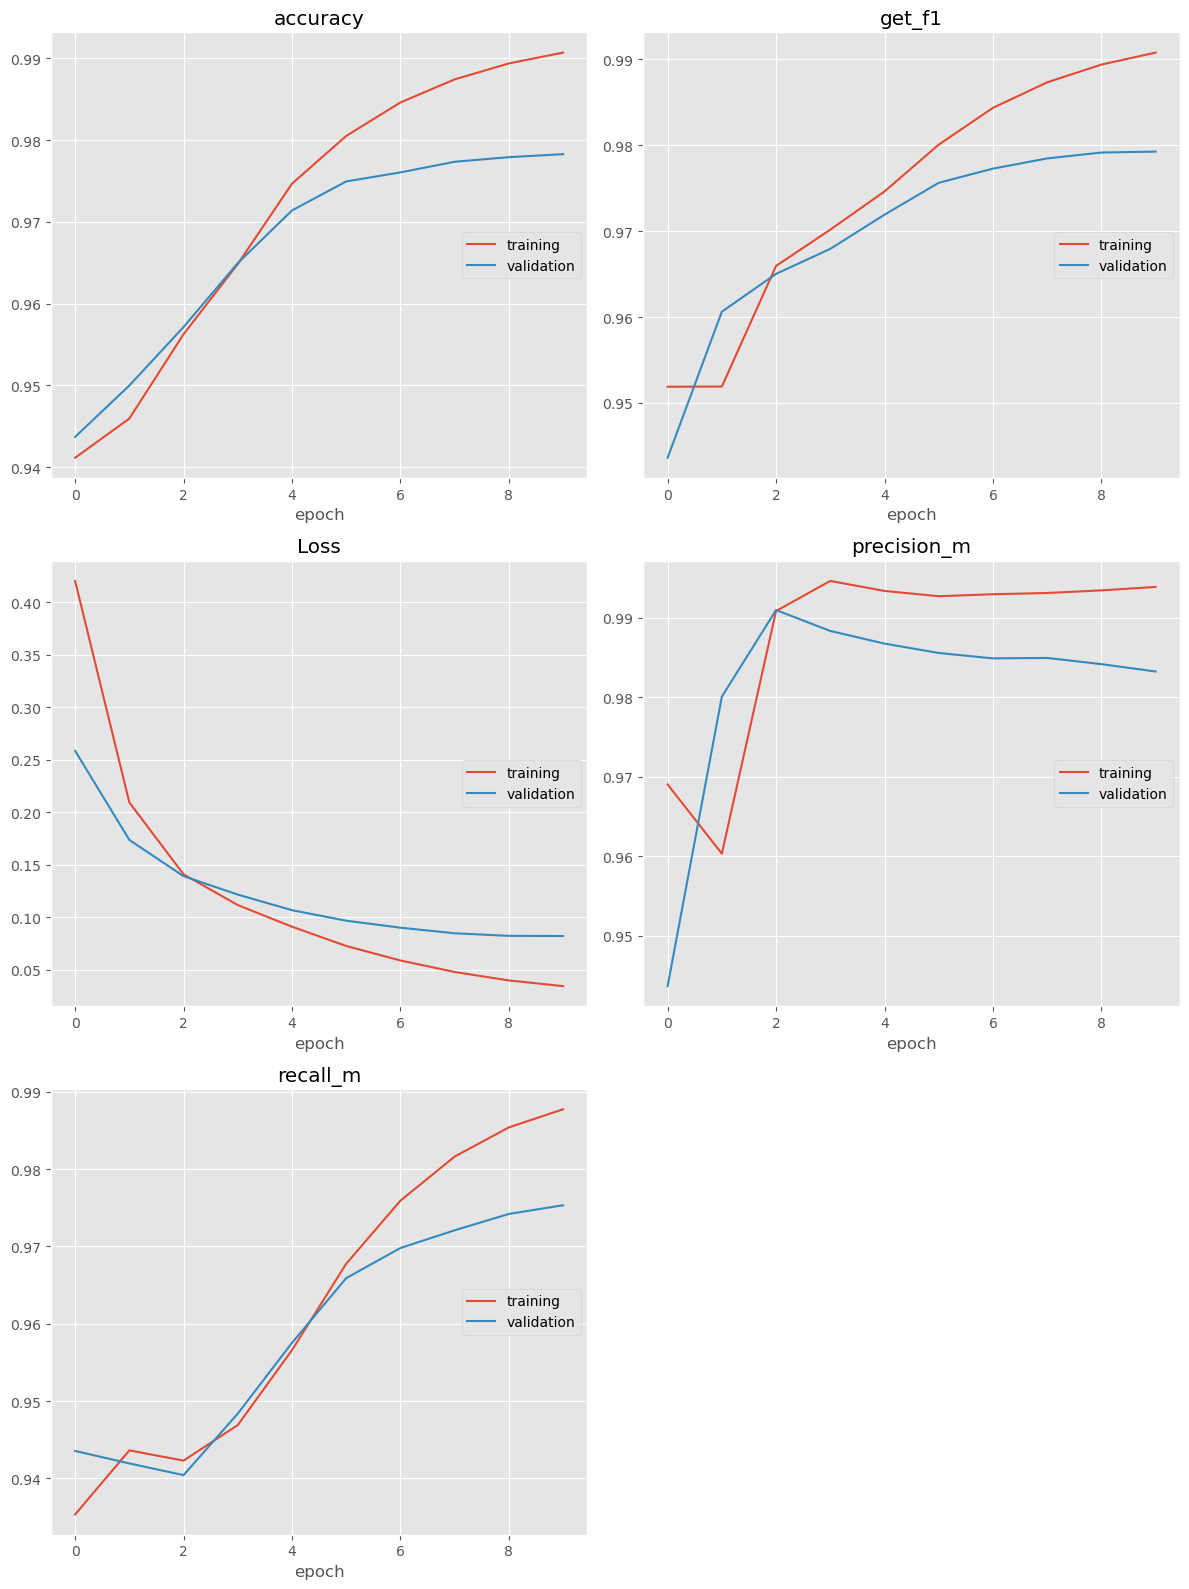

accuracy
	training         	 (min:    0.941, max:    0.991, cur:    0.991)
	validation       	 (min:    0.944, max:    0.978, cur:    0.978)
get_f1
	training         	 (min:    0.952, max:    0.991, cur:    0.991)
	validation       	 (min:    0.944, max:    0.979, cur:    0.979)
Loss
	training         	 (min:    0.034, max:    0.420, cur:    0.034)
	validation       	 (min:    0.082, max:    0.259, cur:    0.082)
precision_m
	training         	 (min:    0.960, max:    0.995, cur:    0.994)
	validation       	 (min:    0.944, max:    0.991, cur:    0.983)
recall_m
	training         	 (min:    0.935, max:    0.988, cur:    0.988)
	validation       	 (min:    0.940, max:    0.975, cur:    0.975)
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.9907 - get_f1: 0.9907 - loss: 0.0353 - precision_m: 0.9937 - recall_m: 0.9877 - val_accuracy: 0.9783 - val_get_f1: 0.9793 - val_loss: 0.0821 - val_precision_m: 0.9832 - val_recall_m: 0.9753


In [31]:
run(data[0: int(len(data)/10)])

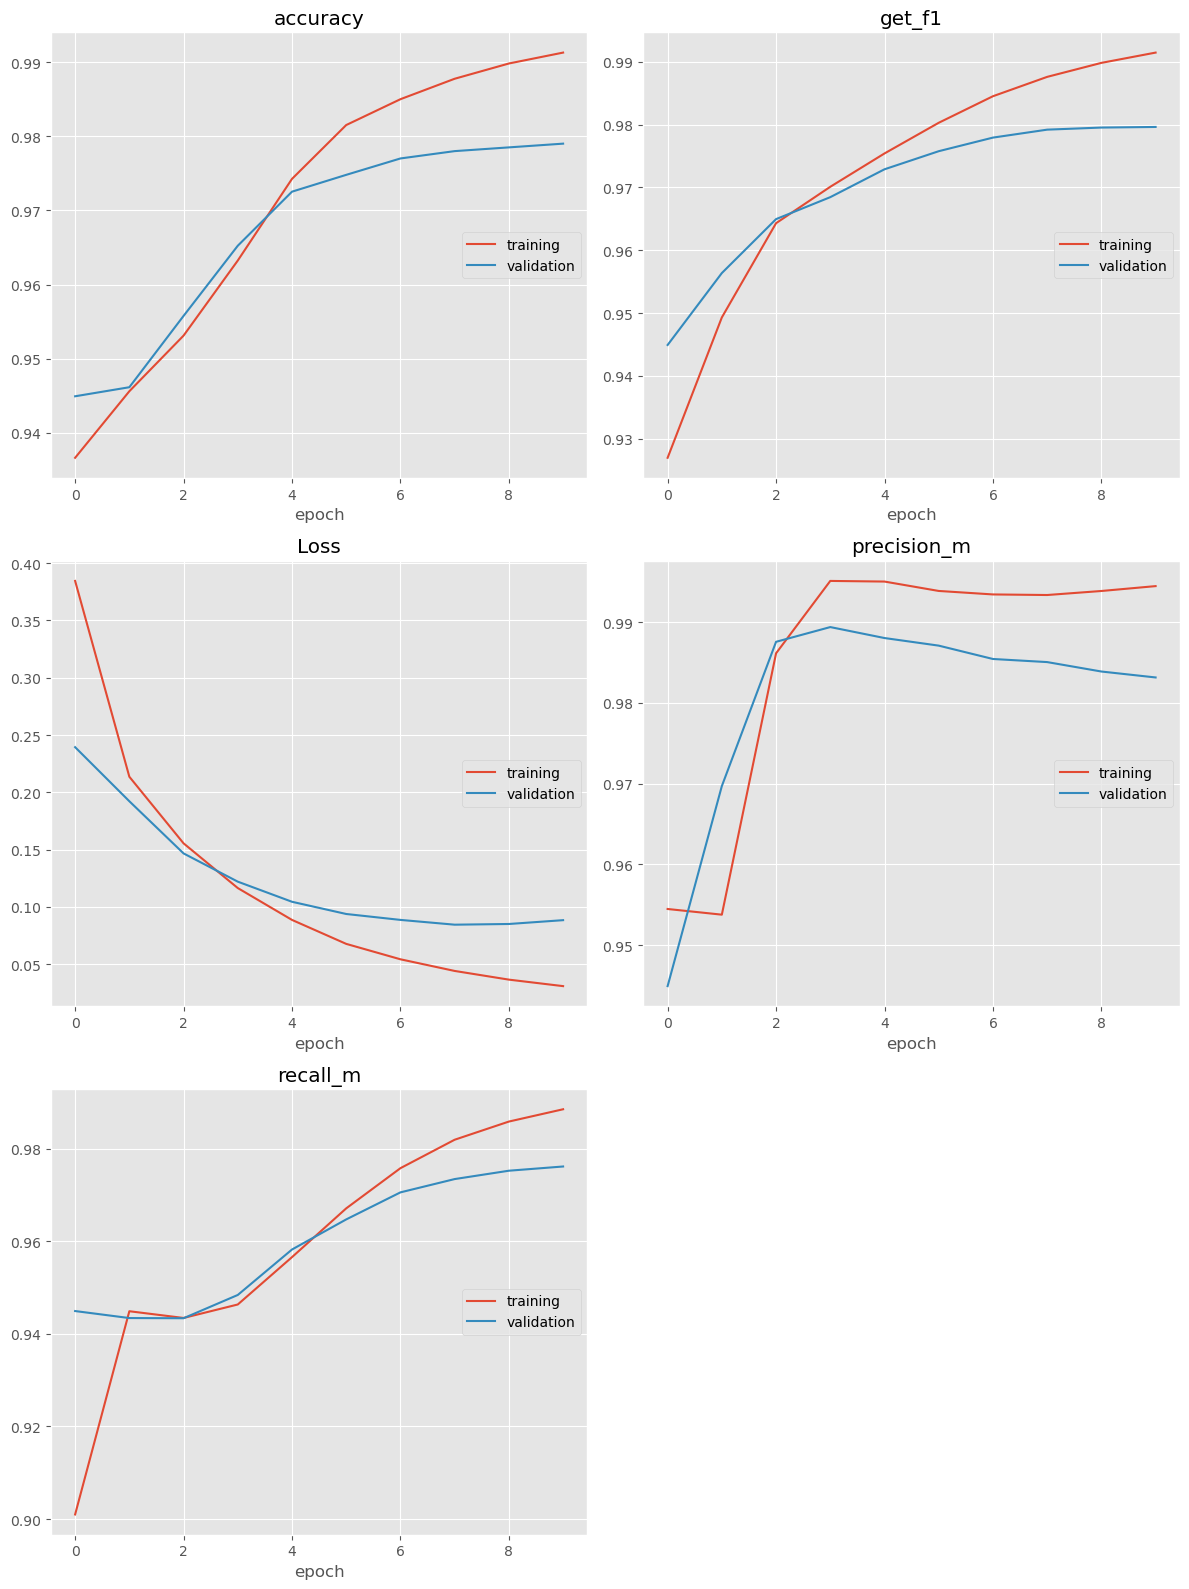

accuracy
	training         	 (min:    0.937, max:    0.991, cur:    0.991)
	validation       	 (min:    0.945, max:    0.979, cur:    0.979)
get_f1
	training         	 (min:    0.927, max:    0.991, cur:    0.991)
	validation       	 (min:    0.945, max:    0.980, cur:    0.980)
Loss
	training         	 (min:    0.031, max:    0.385, cur:    0.031)
	validation       	 (min:    0.084, max:    0.239, cur:    0.088)
precision_m
	training         	 (min:    0.954, max:    0.995, cur:    0.994)
	validation       	 (min:    0.945, max:    0.989, cur:    0.983)
recall_m
	training         	 (min:    0.901, max:    0.988, cur:    0.988)
	validation       	 (min:    0.943, max:    0.976, cur:    0.976)
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.9921 - get_f1: 0.9923 - loss: 0.0287 - precision_m: 0.9951 - recall_m: 0.9894 - val_accuracy: 0.9790 - val_get_f1: 0.9796 - val_loss: 0.0884 - val_precision_m: 0.9831 - val_recall_m: 0.9761


In [32]:
run(datasw)

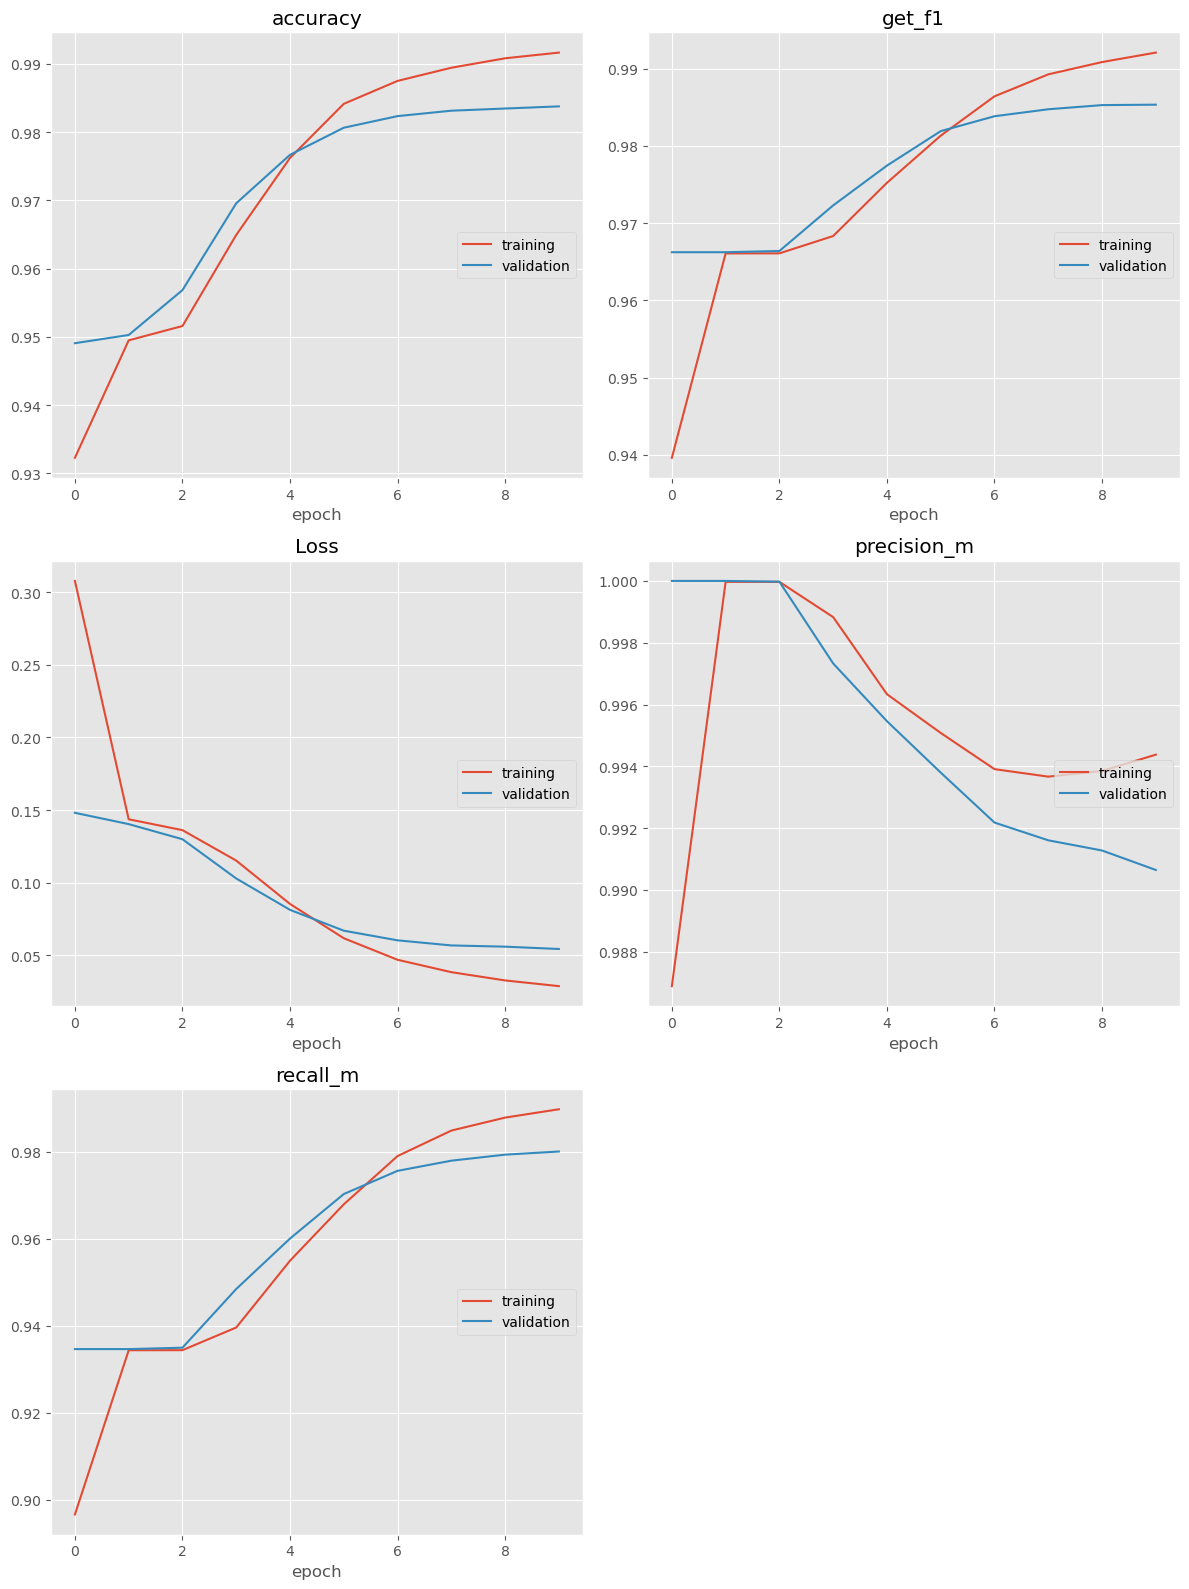

accuracy
	training         	 (min:    0.932, max:    0.992, cur:    0.992)
	validation       	 (min:    0.949, max:    0.984, cur:    0.984)
get_f1
	training         	 (min:    0.940, max:    0.992, cur:    0.992)
	validation       	 (min:    0.966, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.029, max:    0.308, cur:    0.029)
	validation       	 (min:    0.054, max:    0.148, cur:    0.054)
precision_m
	training         	 (min:    0.987, max:    1.000, cur:    0.994)
	validation       	 (min:    0.991, max:    1.000, cur:    0.991)
recall_m
	training         	 (min:    0.897, max:    0.990, cur:    0.990)
	validation       	 (min:    0.935, max:    0.980, cur:    0.980)
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9917 - get_f1: 0.9921 - loss: 0.0296 - precision_m: 0.9944 - recall_m: 0.9898 - val_accuracy: 0.9838 - val_get_f1: 0.9853 - val_loss: 0.0544 - val_precision_m: 0.9906 - val_recall_m: 0.9800


In [33]:
run(dataO)

# **Transfer Learning: Fine-tuning on BC5CDR Dataset**


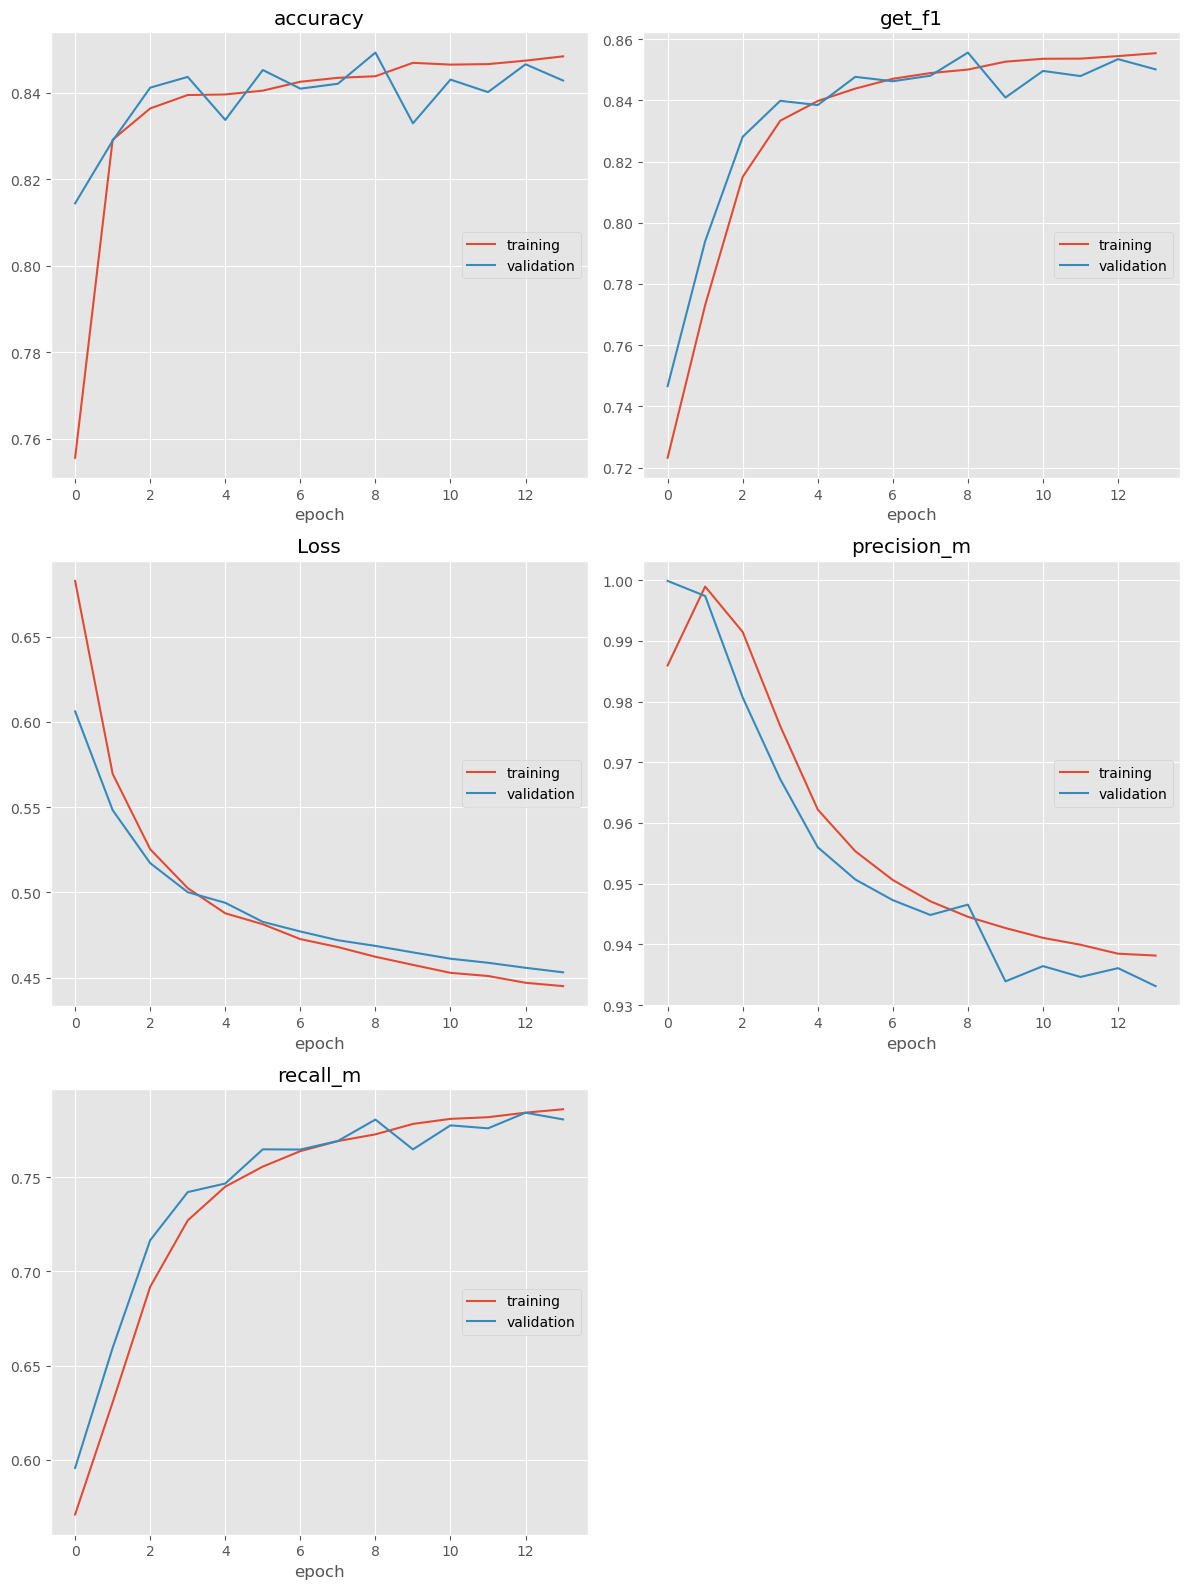

accuracy
	training         	 (min:    0.756, max:    0.848, cur:    0.848)
	validation       	 (min:    0.814, max:    0.849, cur:    0.843)
get_f1
	training         	 (min:    0.723, max:    0.855, cur:    0.855)
	validation       	 (min:    0.747, max:    0.856, cur:    0.850)
Loss
	training         	 (min:    0.445, max:    0.683, cur:    0.445)
	validation       	 (min:    0.453, max:    0.606, cur:    0.453)
precision_m
	training         	 (min:    0.938, max:    0.999, cur:    0.938)
	validation       	 (min:    0.933, max:    1.000, cur:    0.933)
recall_m
	training         	 (min:    0.571, max:    0.786, cur:    0.786)
	validation       	 (min:    0.596, max:    0.784, cur:    0.781)
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.8506 - get_f1: 0.8572 - loss: 0.4398 - precision_m: 0.9393 - recall_m: 0.7882 - val_accuracy: 0.8428 - val_get_f1: 0.8501 - val_loss: 0.4532 - val_precision_m: 0.9331 - val_recall_m: 0.7807
Epoch 14: early stopping
Evaluating on test set...



In [37]:
import json
import os
from keras.optimizers import Adam

# Step 1: Save the pre-trained model
print("Saving pre-trained model...")
model.save_weights("pretrained_ner_model_weights.weights.h5")
print("Pre-trained model weights saved!")

# Step 2: Load BC5CDR dataset from JSON files
print("Loading BC5CDR dataset...")
def load_bc5cdr_json(filepath):
    """Load BC5CDR data from JSON format"""
    sentences = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data = json.loads(line)
                sentences.append((data['tokens'], data['tags']))
    return sentences

# Load label mappings
with open('bc5cdr/dataset/label.json', 'r') as f:
    tag_label_map = json.load(f)
    tag_idx2label = {v: k for k, v in tag_label_map.items()}

# Load training and validation data
train_sentences = load_bc5cdr_json('bc5cdr/dataset/train.json')
valid_sentences = load_bc5cdr_json('bc5cdr/dataset/valid.json')
test_sentences = load_bc5cdr_json('bc5cdr/dataset/test.json')

all_sentences = train_sentences + valid_sentences

# Step 3: Build biomedical vocabulary
biomed_words = sorted(set(word.lower() for tokens, _ in all_sentences for word in tokens)) + ["ENDPAD"]
biomed_tags = sorted(tag_label_map.keys())
biomed_word2idx = {w: i+1 for i, w in enumerate(biomed_words)}
biomed_tag2idx = tag_label_map.copy()
biomed_num_tags = len(biomed_tags)

print(f"Biomedical vocabulary size: {len(biomed_words)}")
print(f"Biomedical tags: {biomed_tags}")

# Step 4: Prepare data
X_biomed = pad_sequences([[biomed_word2idx.get(word.lower(), 0) for word in tokens] for tokens, _ in all_sentences], 
                         maxlen=max_len, padding="post", value=len(biomed_words)-1)
y_biomed = pad_sequences([[tag for tag in tags] for _, tags in all_sentences], 
                         maxlen=max_len, padding="post", value=biomed_tag2idx["O"])
y_biomed = [to_categorical(i, num_classes=biomed_num_tags) for i in y_biomed]

# Prepare test data
X_biomed_test = pad_sequences([[biomed_word2idx.get(word.lower(), 0) for word in tokens] for tokens, _ in test_sentences], 
                              maxlen=max_len, padding="post", value=len(biomed_words)-1)
y_biomed_test = pad_sequences([[tag for tag in tags] for _, tags in test_sentences], 
                              maxlen=max_len, padding="post", value=biomed_tag2idx["O"])
y_biomed_test = [to_categorical(i, num_classes=biomed_num_tags) for i in y_biomed_test]

x_biomed_train, x_biomed_val, y_biomed_train, y_biomed_val = train_test_split(
    X_biomed, y_biomed, test_size=0.2, random_state=42)

print(f"Training samples: {len(x_biomed_train)}, Validation samples: {len(x_biomed_val)}, Test samples: {len(X_biomed_test)}")

# Step 5: Create new model for biomedical NER with same architecture
print("Creating biomedical model with pre-trained weights...")
input_word_biomed = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=len(biomed_words), output_dim=max_len, input_length=max_len)
model_biomed = embedding_layer(input_word_biomed)
model_biomed = SpatialDropout1D(0.1)(model_biomed)
lstm_layer = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))
model_biomed = lstm_layer(model_biomed)
output_layer = TimeDistributed(Dense(biomed_num_tags, activation="softmax"))
model_biomed = Model(input_word_biomed, output_layer(model_biomed))

# Step 6: Transfer weights from pre-trained model
print("Transferring weights from pre-trained model...")
# Verify model structure and get layers correctly
print("Original model layers:")
for i, layer in enumerate(model.layers):
    print(f"  Layer {i}: {type(layer).__name__} - {layer.name}")

# Get original model's layers (Input=0, Embedding=1, SpatialDropout=2, Bidirectional=3, TimeDistributed=4)
original_embedding = None
original_lstm = None
for layer in model.layers:
    if isinstance(layer, Embedding):
        original_embedding = layer
    elif isinstance(layer, Bidirectional):
        original_lstm = layer

if original_embedding is None or original_lstm is None:
    # Fallback: use layer indices
    original_embedding = model.layers[1]
    original_lstm = model.layers[3]

# Get biomedical model layers
biomed_embedding = None
biomed_lstm = None
for layer in model_biomed.layers:
    if isinstance(layer, Embedding):
        biomed_embedding = layer
    elif isinstance(layer, Bidirectional):
        biomed_lstm = layer

if biomed_embedding is None or biomed_lstm is None:
    biomed_embedding = model_biomed.layers[1]
    biomed_lstm = model_biomed.layers[3]

# Transfer LSTM weights (architecture is the same)
print("Transferring LSTM weights...")
biomed_lstm.set_weights(original_lstm.get_weights())
print("LSTM weights transferred successfully!")

# Transfer embedding weights for overlapping vocabulary
print("Mapping embedding weights for overlapping vocabulary...")
original_emb_weights = original_embedding.get_weights()[0]
original_word2idx = word2idx.copy()
new_emb_weights = np.random.normal(0, 0.1, (len(biomed_words), max_len))

# Map overlapping words
overlap_count = 0
for biomed_word, biomed_idx in biomed_word2idx.items():
    if biomed_word in original_word2idx:
        orig_idx = original_word2idx[biomed_word]
        if orig_idx < len(original_emb_weights):
            new_emb_weights[biomed_idx] = original_emb_weights[orig_idx]
            overlap_count += 1

print(f"Mapped {overlap_count} overlapping words from pre-trained embeddings ({overlap_count/len(biomed_words)*100:.1f}%)")
biomed_embedding.set_weights([new_emb_weights])

# Step 7: Calculate class weights to handle severe class imbalance
print("Calculating class weights for imbalanced data...")
from collections import Counter
all_tags = [tag for _, tags in all_sentences for tag in tags]
tag_counts = Counter(all_tags)
total = sum(tag_counts.values())
# Calculate weights: inverse frequency weighting
class_weights = {}
for tag_idx in range(biomed_num_tags):
    tag_label = tag_idx2label[tag_idx]
    count = tag_counts.get(tag_idx, 1)  # Avoid division by zero
    # Balanced class weight: total_samples / (num_classes * class_samples)
    class_weights[tag_idx] = total / (biomed_num_tags * count)
print(f"Class distribution: {dict(tag_counts)}")
print(f"Class weights: {class_weights}")

# Step 8: Fine-tuning strategy - unfreeze layers gradually
print("Configuring fine-tuning strategy...")
# Option 1: Freeze embedding, fine-tune LSTM (recommended for domain adaptation)
biomed_embedding.trainable = False
biomed_lstm.trainable = True

# Option 2: Unfreeze all (if Option 1 doesn't work well, uncomment this):
# biomed_embedding.trainable = True
# biomed_lstm.trainable = True

# Step 9: Compile with lower learning rate for fine-tuning
model_biomed.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy", get_f1, precision_m, recall_m]
)

print("Model architecture:")
model_biomed.summary()

# Step 10: Fine-tune the model with class weights
print("Starting fine-tuning...")
print("Note: Using class weights to handle severe class imbalance.")
print("      Most tokens are 'O', so we weight rare entity classes more heavily.")

# Create a custom loss function that applies class weights
def weighted_categorical_crossentropy(class_weights_dict):
    """Create a weighted categorical crossentropy loss"""
    def loss_fn(y_true, y_pred):
        # Convert class_weights dict to array
        weights_array = np.array([class_weights_dict.get(i, 1.0) for i in range(biomed_num_tags)])
        # Calculate standard categorical crossentropy
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        # Clip predictions for numerical stability
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        # Calculate crossentropy
        ce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        # Get true class indices
        true_class_indices = tf.cast(tf.argmax(y_true, axis=-1), tf.int32)
        # Apply class weights
        weights = tf.gather(tf.constant(weights_array, dtype=tf.float32), true_class_indices)
        weighted_ce = ce * weights
        return tf.reduce_mean(weighted_ce)
    return loss_fn

# Recompile with weighted loss
weighted_loss = weighted_categorical_crossentropy(class_weights)
model_biomed.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=weighted_loss,
    metrics=["accuracy", get_f1, precision_m, recall_m]
)

print("Training with weighted loss function...")
model_biomed.fit(
    x_biomed_train, np.array(y_biomed_train),
    validation_data=(x_biomed_val, np.array(y_biomed_val)),
    batch_size=32,
    epochs=15,  # More epochs with early stopping
    callbacks=[
        EarlyStopping(monitor="val_get_f1", patience=5, mode="max", verbose=1),
        PlotLossesCallback()
    ],
    verbose=1
)

# Step 11: Evaluate on test set
print("Evaluating on test set...")
from sklearn.metrics import f1_score, classification_report

y_pred = np.argmax(model_biomed.predict(X_biomed_test, verbose=0), axis=-1)
y_true = np.argmax(np.array(y_biomed_test), axis=-1)

# Flatten predictions for metrics
y_true_flat = [tag_idx2label[y_true[i][j]] 
               for i in range(len(y_true)) 
               for j in range(len(y_true[i])) 
               if X_biomed_test[i][j] < len(biomed_words)-1]
y_pred_flat = [tag_idx2label[y_pred[i][j]] 
               for i in range(len(y_pred)) 
               for j in range(len(y_pred[i])) 
               if X_biomed_test[i][j] < len(biomed_words)-1]

# Calculate metrics
f1_weighted = f1_score(y_true_flat, y_pred_flat, average='weighted')
f1_macro = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)

# Calculate entity-specific metrics (excluding 'O')
entity_tags = [t for t in biomed_tags if t != 'O']
y_true_entities = [t for t in y_true_flat if t != 'O']
y_pred_entities = [y_pred_flat[i] for i, t in enumerate(y_true_flat) if t != 'O']

if len(y_true_entities) > 0:
    f1_entities = f1_score(y_true_entities, y_pred_entities, average='weighted', zero_division=0)
    print(f"\n=== Fine-tuning Results ===")
    print(f"F1-Score (weighted, all classes): {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
    print(f"F1-Score (macro, all classes): {f1_macro:.4f} ({f1_macro*100:.2f}%)")
    print(f"F1-Score (entities only, excluding 'O'): {f1_entities:.4f} ({f1_entities*100:.2f}%)")
else:
    print(f"\n=== Fine-tuning Results ===")
    print(f"F1-Score (weighted) on BC5CDR test set: {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
    print(f"F1-Score (macro) on BC5CDR test set: {f1_macro:.4f} ({f1_macro*100:.2f}%)")

print(f"\nNote: Weighted F1 is biased toward 'O' class due to severe imbalance (most tokens are 'O').")
print(f"      Entity F1 (excluding 'O') better reflects actual entity recognition performance.")
print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat, labels=biomed_tags, zero_division=0))

# Overfitting check
print(f"\n=== Overfitting Analysis ===")
print("Compare training vs validation vs test metrics:")
print("If train >> validation >> test, you're overfitting.")
print("If train ≈ validation but test is much worse, check for:")
print("  - Distribution shift between train/test")
print("  - Insufficient regularization")
print("  - Model memorizing patterns instead of learning")


In [ ]:
# Duplicate cell - all transfer learning code is in cell 54
